In [67]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random
from sklearn import datasets, mixture 
from sklearn.cluster import DBSCAN
import imageio
import matplotlib.gridspec as gridspec
    
'''   
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
'''

'   \ndef fxn():\n    warnings.warn("deprecated", DeprecationWarning)\n\nwith warnings.catch_warnings():\n    warnings.simplefilter("ignore")\n    fxn()\n'

In [68]:
%pwd

'/Users/thomasspringett/github/heartrate'

# Project Objectives
This project will analyze heart rate data to determine if machine learning and clustering algorithms can indetify a high intensity zone for a given individual. The process will be to load and filter the data, select a sample, and plot the data with the various limits to determine how the zones are impacted. Several clustering models will be evaluated using performance metrics. 

# Loading and Pre-Processing

The dataset is from one 63 year old white male exported from the Apple Health app. No features were available. For ill be analyzed.The .csv file was over 100MB, the limit for github. Consequently the data file was converted into a pickle file and is loaded below.

In [79]:
# The dataset for this project consist of heart rate data collected over 4 years 
# during various physical activities: biking, walking, skiing. 

#csv_file = 'data/HeartRateDataRaw.csv'
#df_raw = pd.read_csv(csv_file, header=0)
#df_raw.to_pickle('./data/HeartRateDataRaw.pickle')
df_raw=pd.read_pickle('./data/HeartRateDataRaw.pickle')
df_raw.head()

,/@locale,/ExportDate/@value,/Me/@HKCharacteristicTypeIdentifierBiologicalSex,/Me/@HKCharacteristicTypeIdentifierBloodType,/Me/@HKCharacteristicTypeIdentifierDateOfBirth,/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType,/Record/@creationDate,/Record/@device,/Record/@endDate,/Record/@sourceName,/Record/@sourceVersion,/Record/@startDate,/Record/@type,/Record/@unit,/Record/@value,/Record/MetadataEntry/@key,/Record/MetadataEntry/@value,/Record/MetadataEntry/@value/#agg
0,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,12/21/14 19:13,NaN,12/21/14 19:13,Health,NaN,12/21/14 19:13,HKQuantityTypeIdentifierBodyMassIndex,count,26.29000,HKWasUserEntered,1.0,1.0
1,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,10/2/14 17:40,NaN,10/2/14 17:40,Health,NaN,10/2/14 17:40,HKQuantityTypeIdentifierHeight,ft,5.66667,HKWasUserEntered,1.0,1.0
2,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,11/24/14 15:22,NaN,11/24/14 15:22,Health,NaN,11/24/14 15:22,HKQuantityTypeIdentifierHeight,ft,4.83333,HKWasUserEntered,1.0,1.0
3,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,8/8/15 19:20,NaN,8/8/15 19:20,Toms iPhone6,NaN,8/8/15 19:20,HKQuantityTypeIdentifierHeight,ft,5.66667,NaN,NaN,NaN
4,en_US,8/23/20 10:28,HKBiologicalSexMale,HKBloodTypeOPositive,10/22/57,HKFitzpatrickSkinTypeNotSet,8/8/15 19:29,NaN,8/8/15 19:29,Thomas's Apple Watch,NaN,8/8/15 19:29,HKQuantityTypeIdentifierHeight,ft,5.66667,NaN,NaN,NaN


In [80]:
# Displaying the list of column names in the heart rate export: 
for col in df_raw.columns:
    print (col)

/@locale
/ExportDate/@value
/Me/@HKCharacteristicTypeIdentifierBiologicalSex
/Me/@HKCharacteristicTypeIdentifierBloodType
/Me/@HKCharacteristicTypeIdentifierDateOfBirth
/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType
/Record/@creationDate
/Record/@device
/Record/@endDate
/Record/@sourceName
/Record/@sourceVersion
/Record/@startDate
/Record/@type
/Record/@unit
/Record/@value
/Record/MetadataEntry/@key
/Record/MetadataEntry/@value
/Record/MetadataEntry/@value/#agg


## Selecting Fields of Interest
The only feature of interest is '/Record/@value'. It contains the beats per minute data. The other fields could be of interest, but they were either not populated, had only a single value (sex = male) or not expected to be relevant (skin type). The code below selects only the '/Record/@value' parameter and renames it to 'BPM'. In an ideal dataset scenario, multiple people of both sexes, a wide range of ages and different devices would also be included. For this exploratory analysis, this limited dataset should be sufficient. 

In [81]:
# Saving and renaming only the BPM values: 
df_raw = df_raw.filter(items=['/Record/@value'])
df_raw = df_raw.rename(columns={'/Record/@value':"BPM"})
df_raw.head()

,BPM
0,26.29000
1,5.66667
2,4.83333
3,5.66667
4,5.66667



# Setting Parameters and Limits
### Hardware Limits, Sample Size, Maximum HR 

The heart rate data was obtained from an Apple Watch and exported from Healthkit. Do to the sensitivity and availability of health data, the dataset is collected from only one white 63 year old male. The watch sensor's valid hardware limits are from 30 bpm to 210 bpm. Values outside of this range were filtered. Do to the large database with over 349,000 data points, a random sample of 10,000 from this population was generated. This did not significantly affect the distribution or results but did improve execution time. 

Maximum heart can be calculated from age. The formula is 220-age. There is no comparable algorithm for minimum heart rate. In general, a lower resting heart rate is indicative of better conditioning. 

In [82]:
# Configuration Parameters including hardware sensor limits, maximum heart rate and sample size are defined. 
# To calculate maximum heart rate, the formula 220 - age is used. 
age = 63 
max_hr = 220-age
sample_size = 10000
hardware_upper_limit = 210
hardware_lower_limit = 30

### Heart Rate Zone Limits

Various heart rate zones have been defined. They range from resting to high intensity zones. There is no standard. Polar heart rate monitors have been in use by atheletes for decades and have 5 zones. The CDC and Mayo clinic define two exercise zones, moderate and intense. While the zones for each of these sources have different limits, all use the same calculation for maximum hear rate, namely 220-age. Clustering algorithms will also be applied to the data with each cluster defining a zone. 

The limits for the CDC, Polar and Mayo Clinic zones are defined in the dictionaries below: 

In [83]:
#Dictionaries are defined for Mayo Clinic, CDC and Polar (tm) heart rate zones: 
mayo_limits = {'moderate_low':0.50*max_hr,'moderate_hi':0.7*max_hr,'intensity_low':0.70*max_hr,'intensity_hi':0.85*max_hr}
cdc_limits = {'moderate_low':0.64*max_hr,'moderate_hi':0.76*max_hr,'intensity_low':0.76*max_hr,'intensity_hi':0.93*max_hr}
polar_limits = {'zone1':0.6*max_hr,'zone2':0.7*max_hr,'zone3':0.80*max_hr,'zone4':0.9*max_hr,'zone5':1*max_hr}

# Explore the Data
It is now time to explore the data. A display of the raw dataframe, summary
statistics and graphical analysis will all be used to understand the dataset. 
### Descriptive Statistics
The above summary shows that there were 349,781 heat beat measurements. The minimum was 5 and the maximum is 215. These values are outside of the sensor's valid range, which is 30 to 210. Consequently, they will be filtered out. 
The mean at 78 bpm is significantly above the median at 69 bpm, suggesting there the distribution has a high end tail. The standard distribution of 24 is also high further suggesting a wide range of values. 

In [85]:
display (df_raw.head())
# The summary statistics for heart rate data on the full dataset: 
display (round(df_raw.BPM.describe()))

,BPM
0,26.29000
1,5.66667
2,4.83333
3,5.66667
4,5.66667


count    349781.0
mean         78.0
std          24.0
min           5.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64

### Filter Outliers
The hardware limits noted above will be applied to the dataset: 

In [86]:
# Apply hardware limits:
df_limit = df_raw[(df_raw['BPM'] < hardware_upper_limit) & (df_raw['BPM'] > hardware_lower_limit) ]
num_screened = df_raw.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} instances.".format(hardware_upper_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 330 instances.


### Sampling 
In order to reduce execution times, a sample was drawn from the original population. The sample size was 10,000. Descriptive statistics were again generated on this sample and the distibution is virtually unchanged. The results are presented below:

In [87]:
#To improve execution times, a random sample of 10,000 from the population of 349,768 is drawn. By comparing the 
#percentiles of the population above to that of the sample below, it can be seen the sample actuately 
#reflects the population. 

df_s=random.sample(list(df_raw.BPM), sample_size)
df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']
print (round(df_sample.describe()))

           BPM
count  10000.0
mean      78.0
std       24.0
min        6.0
25%       61.0
50%       69.0
75%       86.0
max      215.0


## Adding Benchmark Limits to the Dataset Zones
The next section of code will add target heart rate limits for various zones from the CDC, Polar and Mayo Clinic.  

In [89]:
def assignPolarZone(value):
    '''
    Polar Heart rate zones are defined below.
    '''
    if (value <= polar_limits['zone1']): 
        return "zone1"
    elif (value > polar_limits['zone1']) and (value <= polar_limits['zone2']):
        return "zone2"
    elif (value > polar_limits['zone2']) and (value <= polar_limits['zone3']):
        return  "zone3"
    elif (value > polar_limits['zone3']) and (value <= polar_limits['zone4']):
        return  "zone4"    
    elif (value > polar_limits['zone4']) and (value <=polar_limits['zone5']):
        return "zone5"
    else:
        return

print ("Polar: {} {} {} {} {} ".format(int(polar_limits['zone1']),int(polar_limits['zone2']),int(polar_limits['zone3']),int(polar_limits['zone4']),int(polar_limits['zone5'])))

Polar: 94 109 125 141 157 


In [90]:
print ("CDC Limits: ",int(cdc_limits['moderate_low']),int(cdc_limits['moderate_hi']), int(cdc_limits['intensity_low']),int(cdc_limits['intensity_hi']))
def assignCDCZone(value):
    '''
    CDC Definitions are defined here:
    '''
    if (value > cdc_limits['moderate_low']) and (value <= cdc_limits['moderate_hi']):
        return "Moderate"
    elif (value > cdc_limits['intensity_low']) and (value <= cdc_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

CDC Limits:  100 119 119 146


In [91]:
print ("Mayo Clinic Limits: ",int(mayo_limits['moderate_low']),int(mayo_limits['moderate_hi']), int(mayo_limits['intensity_low']),int(mayo_limits['intensity_hi']))
def assignMayoZone(value):
    '''
    Mayo Clinic heart rate zones are defined below
    '''
    if (value > mayo_limits['moderate_low']) and (value <= mayo_limits['moderate_hi']):
        return "Moderate"
    elif (value > mayo_limits['intensity_low']) and (value <= mayo_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

Mayo Clinic Limits:  78 109 109 133


In [93]:
# This section uses the 'apply' function to generate 3 new columns, one for each source of target heart rate limits: CDC, Polar and Mayo Clinic. 
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignPolarZone)
df_zones['CDC_Zone'] = df_zones.BPM.apply(assignCDCZone)
df_zones['Mayo_Zone'] = df_zones.BPM.apply(assignMayoZone)

print ("\nHere is what the dataframe header looks like with these zones applied:")
df_zones.head()


Here is what the dataframe header looks like with these zones applied:


,BPM,Polar_Zone,CDC_Zone,Mayo_Zone
0,57.0,zone1,Other,Other
1,71.0,zone1,Other,Other
2,63.0,zone1,Other,Other
3,90.0,zone1,Other,Moderate
4,67.0,zone1,Other,Other


In [94]:
#Checking for Zone assignment: 
print ("Polar: ",df_zones['Polar_Zone'].unique())
print ("CDC  : ",df_zones['CDC_Zone'].unique())
print ("Mayo : ",df_zones['Mayo_Zone'].unique())

Polar:  ['zone1' 'zone4' 'zone2' 'zone5' 'zone3' None]
CDC  :  ['Other' 'Intensity' 'Moderate']
Mayo :  ['Other' 'Moderate' 'Intensity']


In [35]:
df2 = df_zones.copy() 

## Clustering and the Distribution
The next section will superimpose the zones on the histogram. 
First step is to write the code:

In [122]:
def hr_newzone_histogram(df,source,show): 
    '''
       This method takes the heart rate zone limits from 3 different sources and applies
       them to the given distribution. 
    '''
    xref = [max_hr]
    ref_colors=['r']
    plt.figure(figsize=(5,3))

    plt.figure(figsize=(5,3))
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    plt.title(source + ' Clinic Zone Heart Rate Distribution')
    
    
    if source == 'kmeans':
        if  'Label' in df: 
            df.drop("Label",axis='columns',inplace=True)

        kmeans = KMeans(n_clusters=5)
        labels = kmeans.fit_predict(df2.BPM.values.reshape(-1,1))
        if  'Label' in df2: 
            df2.drop("Label",axis='columns',inplace=True)
        df2.insert(1,"Label",labels)
        
        zone1 = df.loc[df.Label ==0, 'BPM']
        zone2 = df.loc[df.Label ==1, 'BPM']
        zone3 = df.loc[df.Label ==2, 'BPM']
        zone4 = df.loc[df.Label ==3, 'BPM']
        zone5 = df.loc[df.Label ==4, 'BPM']

        plt.hist(zone1, **kwargs, color='g', label='Cluster1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Cluster2',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Cluster3',bins=range(35, 205+2, 2))
        plt.hist(zone4, **kwargs, color='y', label='Cluster4',bins=range(35, 205+2, 2))
        plt.hist(zone5, **kwargs, color='c', label='Cluster5',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/cluster_histo.png')

        
    elif source == 'Raw':
        plt.hist(df.BPM, **kwargs, color='b', label='Raw Data',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/raw_histo.png')

    elif source == 'CDC':
        zone1 = df.loc[df.CDC_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.CDC_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.CDC_Zone == 'Other', 'BPM']
        plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/cdc_histo.png')
        
    elif source == 'Mayo':
        zone1 = df.loc[df.Mayo_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.Mayo_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.Mayo_Zone == 'Other', 'BPM']
        plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/mayo_histo.png')
        
    elif source == 'Polar':
        zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
        zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
        zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
        zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
        zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
        plt.hist(zone1, **kwargs, color='g', label='zone1',bins=range(35, 205+2, 2))
        plt.hist(zone2, **kwargs, color='b', label='zone2',bins=range(35, 205+2, 2))
        plt.hist(zone3, **kwargs, color='r', label='zone3',bins=range(35, 205+2, 2))
        plt.hist(zone4, **kwargs, color='y', label='zone4',bins=range(35, 205+2, 2))
        plt.hist(zone5, **kwargs, color='c', label='zone5',bins=range(35, 205+2, 2))
        plt.legend()
        plt.savefig('./plots/polar_histo.png')
    else: 
        print ("Source not recognized. Need CDC, Polar, kmeans, Mayo or Cluster.")
   
    for ref, c in zip(xref,ref_colors):
         plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))

    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
  
    if show == 'noshow':
        plt.close()
    else:
        plt.show()


In [123]:
hr_newzone_histogram(df2,'kmeans','noshow')

<Figure size 360x216 with 0 Axes>

In [124]:
hr_newzone_histogram(df2,'Raw','noshow')

<Figure size 360x216 with 0 Axes>

In [125]:
hr_newzone_histogram(df2,'Polar','noshow')

<Figure size 360x216 with 0 Axes>

In [126]:
hr_newzone_histogram(df2,'CDC','noshow')

<Figure size 360x216 with 0 Axes>

In [127]:
hr_newzone_histogram(df2,'Mayo','noshow')

<Figure size 360x216 with 0 Axes>

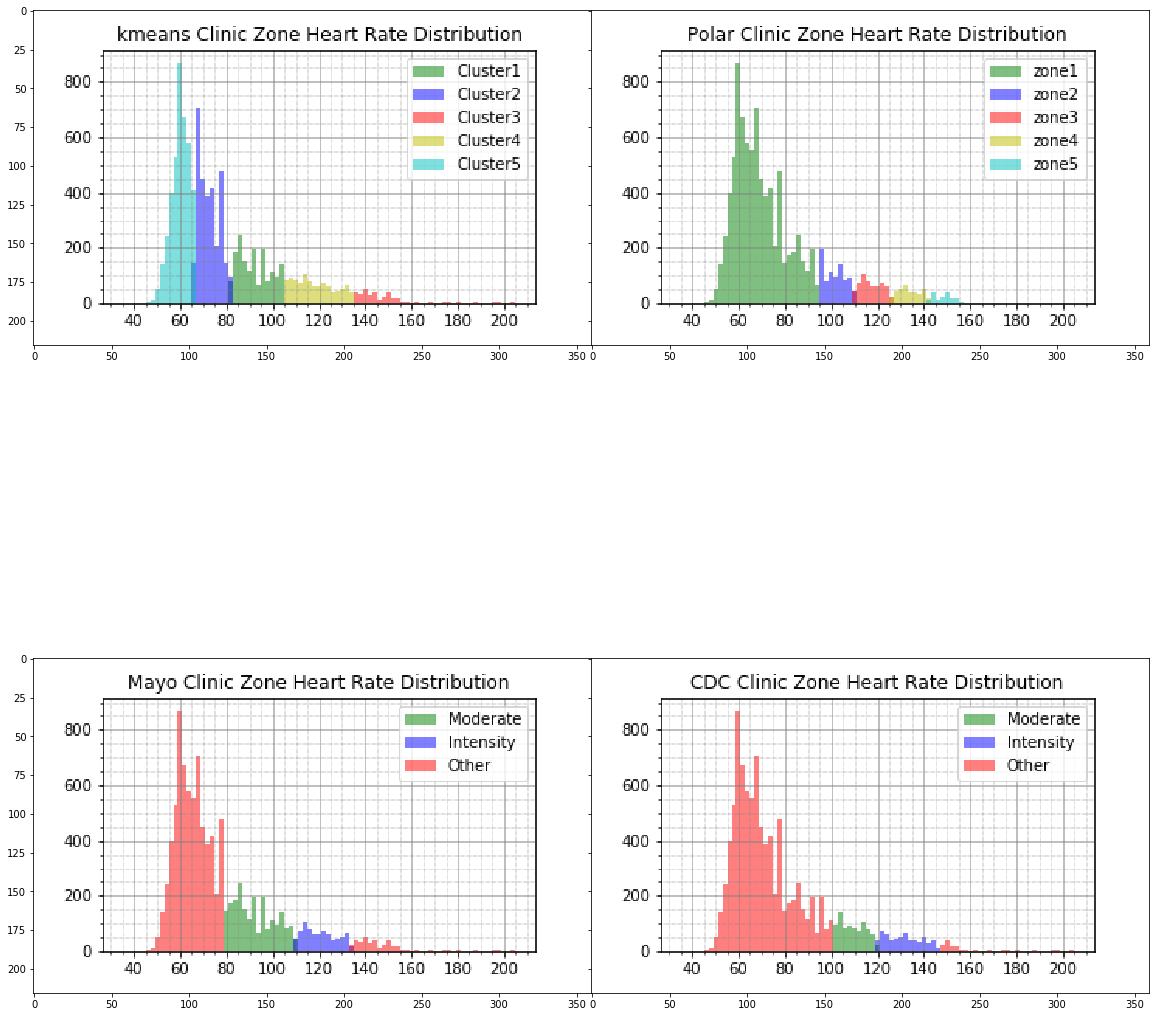

In [128]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,sharey=True)

img1 = imageio.imread('./plots/cluster_histo.png')
img2 = imageio.imread('./plots/polar_histo.png') 
img3 = imageio.imread('./plots/mayo_histo.png')
img4 = imageio.imread('./plots/cdc_histo.png')

plt.rcParams["figure.figsize"] = (20,20)
#gs1 = gridspec.GridSpec(4, 4)
#gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes
fig.subplots_adjust(wspace=0, hspace=0,bottom = 0,top = 0.9)

#fig,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)
#plt.subplot(2,1,1)
#plt.figure()

ax1.imshow(img1)                     
#plt.subplot(212) 
ax2.imshow(img2) 
ax3.imshow(img3) 
ax4.imshow(img4) 
plt.show()

## Pre-Processing Summary
The dataset has been loaded, columns of interest selected, data filtered and a smaller sample generated to speed execution. Summary statistics and graphical analysis have also been completed. This is a simple 1D dataset with no features or labels.

The most siginificant take-away, highlighted by the distribution,  is that there does not appear to be any clusters. The is no clear separation in any of the data. However, the analysis will continue. The models, particularly a Guassian Mixture Model, may be able to tease apart at least a second distribution. 

Note also that training and test datasets have not been generated. This is becaused it is un-supervised learning. There are no labels for model predictions to be compared against. Instead a 'score', explained more below, will be used to evaluate the model with the best fit. 

# Modeling 
Since the data is not labeled, unsupervised clustering techniques will be utilized. Three models are evaluated: Kmeans, GMM and DBSCAN. The silhouette score will be used as a performance metric to determine the best model. 
## KMeans 
This model was selected as it does not required labeled data and it is intuitive to understand. One primary question to be answered is whether or not a high intensity, high heart rate cluster can be indentified. This would allow for personalized zones. 
### Fitting, Predicting and Evaluating the Model
The primary hyperparameter of interest is the number of clusters. It is the first step in optimizing the model. Values from 2 to 10 were used. The data was fit and model predictions were used to define labels. 

The KMeans performance metric is called its score or inertia. It measures the mean square distance from the instance to the cluster centroid. Lower numbers are considerted to be better. 

The code below 

In [129]:
def scree_KMeans_plot(data,num_clusters):
    ''' This method will calculate Kmeans clusters. The number of clusters will be defined by a range. 
        Kmeans will be used to define the clusters and labels for the data generated. Finally the data 
        will be ploted so the Elbow method can be used to determine the optimum number of clusters. 
    '''
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    plt.figure(figsize=(5,3))
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        #print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        #print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        #print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Elbow Method: Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    #print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels

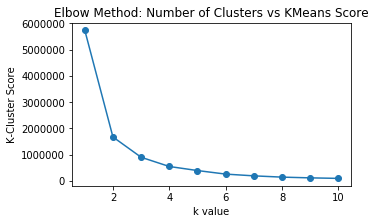

In [130]:
k_values, scores, labels = scree_KMeans_plot(df_sample,11) 

#### KMeans Score or Inertia
For each of the clusters numbered 2 to 10, the score was calculated and compared to k. The elbow plot is above. It can be seen that after 5 clusters the improvment in score diminishes. 

Another method, listed below, was written to specify a percentage improvement in the score at which the addition of more clusters is no longer beneficial.  

In [132]:
findK(scores,30) #helper function to determine percent improvement cutoff

Maximum value of number of clusters (k) is:  10
Less than 30% improvement in score after k = 4


#### KMeans Silhouette Score
A second performance metric was also used to evaluate the model performance. It is called the silhouette score and is more robust than the inertia score.  It comprehends both cohesion, or intra-cluster distances,  as well as the inter-cluster distances, or separation.

The silhouette coefficient can vary from -1 to 1. Values near 1 mean that the instance is well within its cluster and far from other clusters. So higher is better. As can be seem from the plot above, the best fit is with a cluster of 2. Note that 2 is the minimum number of clusters that can be used for the silhouette calculation. 

The silhouette score is contradicting the kmeans score. The silhouette score is more sensitive to cluster separation and is a more accurate measure of performance.

### Clustering Partitions on the Distribution
This histogram show clearly that although KMeans succesfully partioned the data into clusters, there is no separation between clusters, suggesting the model has overfit the data. 

## Benchmarking
The next section will compare how several sources, the Mayo Clinic, the CDC and the Polar Heart Rate company, define high intensity heart rates zones. These zones will be used as benchmarks for the ones defined by the clustering algorithm. 

The overall process is outlined below. 
###  Maximum Heart Rate
The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 220 - age. 0r 158bpm for a 62 year old.
2. Heart Rate Monitor data collected over a period of months with various activities. 
3. Using a treadmill or stationary bike with an ECG. 
Option number 1 is the most common for folks that do not have access to the treadmill and ECG. It is remarkable how well it works. The body seems to have a built in algorithm.  
After the maximum heart rate is determined, target heart rates can be determined:

### Hear Rate Intensity Zones

#### CDC
The CDC defines zones as follows: 
* Target Heart Rate is 64% to 76%. CDC. 
* High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 

#### MayoClinic
The Mayo Clinic defines 

1. Moderate intensity as 50-70% of maximum heart rate.
2. Vigorous as 70% to 85%.

#### Polar
The heart rate monitor company Polar suggests 5 heart rate zones:

1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 

The code below will assign new columns in the dataset that categorize the heart rate into the zones covered above: 


#### Displaying the Histograms
The four histograms, one each for the clusters, CDC, Mayo and Polar are shown: 

In [139]:
%%time
def silhouetteScore(df,num_clusters):
    models = ['kmeans', 'gmm', 'dbscan']
    sil_scores = []
    k_value = []
    model_type = []
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
            for mymodel in models:
                    if mymodel == 'kmeans':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            kmeans = KMeans(n_clusters=n_clusters)
                            cluster_labels = kmeans.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                    
                    elif mymodel == 'gmm': 
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            gmm = mixture.GaussianMixture(n_components=n_clusters)
                            cluster_labels = gmm.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                    
                    elif mymodel == 'dbscan':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            dbscan = DBSCAN(eps=27, min_samples= 100)
                            cluster_labels = dbscan.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            #print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
 
    print ("\nFinished!")
    return sil_scores, k_value, model_type

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [140]:
%%time
sil_scores, k_value, model_type = silhouetteScore(df_sample.BPM.values.reshape(-1,1),11)

Model kmeans with n_clusters = 2, silhouette score is 0.71
Model gmm with n_clusters = 2, silhouette score is 0.66
Model kmeans with n_clusters = 3, silhouette score is 0.64
Model gmm with n_clusters = 3, silhouette score is 0.63
Model kmeans with n_clusters = 4, silhouette score is 0.59
Model gmm with n_clusters = 4, silhouette score is 0.6
Model kmeans with n_clusters = 5, silhouette score is 0.59
Model gmm with n_clusters = 5, silhouette score is 0.55
Model kmeans with n_clusters = 6, silhouette score is 0.56
Model gmm with n_clusters = 6, silhouette score is 0.56
Model kmeans with n_clusters = 7, silhouette score is 0.56
Model gmm with n_clusters = 7, silhouette score is 0.51
Model kmeans with n_clusters = 8, silhouette score is 0.56
Model gmm with n_clusters = 8, silhouette score is 0.55
Model kmeans with n_clusters = 9, silhouette score is 0.56
Model gmm with n_clusters = 9, silhouette score is 0.56
Model kmeans with n_clusters = 10, silhouette score is 0.53
Model gmm with n_clus

In [141]:
#print (list(all))
df =pd.DataFrame(list(zip(sil_scores,k_value,model_type)),columns=['sil_score','k','model'])
display (df.head(5))
display (df.iat[3,0])

,sil_score,k,model
0,0.71,2,kmeans
1,0.66,2,gmm
2,0.79,2,dbscan
3,0.64,3,kmeans
4,0.63,3,gmm


0.64

In [143]:
def silhouette_plot(df):
    
    kmeans = df.loc[df.model == 'kmeans']
    gmm = df.loc[df.model == 'gmm']
    dbscan = df.loc[df.model == 'dbscan']
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('k value')
    plt.title('Selecting K for Best Silhouette Score \n Models = KMeans, GMM, DBSCAN')
    plt.ylim=(0.3,1.0)
    plt.grid(True)
    plt.plot(kmeans.k,kmeans.sil_score,  label = 'kmeans', marker = 'o')
    plt.plot(gmm.k,gmm.sil_score,  label = 'gmm', marker = 'o')
    plt.plot(dbscan.iat[0,1],dbscan.iat[0,0],  label = 'gmm', marker = 'o')
    #plt.plot(dbscan.k[0],d,  label = 'gmm', marker = 'o')

    plt.xticks(np.arange(1.0, 11, 1.0))
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.legend(['kmeans', 'gmm','dbscan'])
    plt.show()

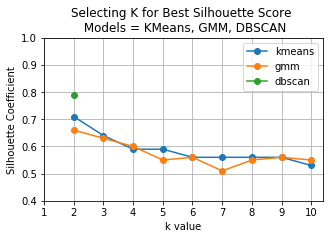

In [144]:
silhouette_plot(df)

CPU times: user 17.4 s, sys: 4.58 s, total: 22 s
Wall time: 22 s


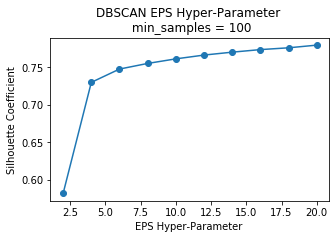

In [145]:
%%time
scores = []
eps = []
for x in range(2,21,2):
    dbscan = DBSCAN(eps=x, min_samples= 100)
    dbscan.fit(df_sample.BPM.values.reshape(-1,1))
    score = silhouette_score(df_sample.BPM.values.reshape(-1,1),dbscan.labels_)
    scores.append(score)
    eps.append(x)
    #print (x,np.unique(dbscan.labels_),round(score,2))
plt.figure(figsize=(5,3))
plt.ylabel('Silhouette Coefficient')
plt.xlabel('EPS Hyper-Parameter ')
plt.title('DBSCAN EPS Hyper-Parameter \n min_samples = 100')
plt.plot(eps,scores,  label = 'eps', marker = 'o')

### Discussion 
The clustering algorithm defines 5 zones but the boundaries seem artifical. The Polar algoritm seems to suffer from the same plight, but has a larger resting (Zone 1 & Zone 2) percentage. The Mayo Clinc and CDC Zones have an intensity session defined that provides a buffer to the maximum heart rate. 

### Next Steps 
Providing more features and data from more persons need to be added to the dataset. 